# Explain Like I'm 5

![Architecture](images/architecture.png)

In this notebook, we're going to walk through setting up a simple chatbot in LangGraph. 

Throughout this process, we're going to show how LangSmith can be used to improve the developer experience for AI applications. 

Let's start by loading our environment variables from our .env file. 

In [2]:
from dotenv import load_dotenv
load_dotenv(dotenv_path=".env", override=True)
# Loads the following env variables
# LANGSMITH_TRACING=true
# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_PROJECT="eli5-bot"
# LANGSMITH_API_KEY="<redacted>"

# OPENAI_API_KEY="<redacted>"
# TAVILY_API_KEY="<redacted>"

True

## Setup

Let's set up a tool called Tavily to allow our assistant to search the web when answering

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=1)

Let's design a prompt for RAG that we'll use throughout the notebook.

In [4]:
prompt = """You are a professor and expert in explaining complex topics in a way that is easy to understand. 
Your job is to answer the provided question so that even a 5 year old can understand it. 
You have provided with relevant background context to answer the question.

Question: {question} 

Context: {context}

Answer:"""
print("Prompt Template: ", prompt)

Prompt Template:  You are a professor and expert in explaining complex topics in a way that is easy to understand. 
Your job is to answer the provided question so that even a 5 year old can understand it. 
You have provided with relevant background context to answer the question.

Question: {question} 

Context: {context}

Answer:


## Creating Our Application

In [5]:
from openai import OpenAI
from langsmith import traceable
from langsmith.wrappers import wrap_openai

openai_client = wrap_openai(OpenAI())

@traceable
def search(question):
    web_docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in web_docs])
    return web_results
    
@traceable
def explain(question, context):
    formatted = prompt.format(question=question, context=context)
    
    completion = openai_client.chat.completions.create(
        messages=[
            {"role": "system", "content": formatted},
            {"role": "user", "content": question},
        ],
        model="gpt-4o-mini",
    )
    return completion.choices[0].message.content

@traceable
def eli5(question):
    context = search(question)
    answer = explain(question, context)
    return answer

## Testing Our Application

In [6]:
question = "What is LangChain?"
print(eli5(question))

LangChain is like a special toolbox that helps people build smart programs that can understand and use language, just like we do! Imagine if you have a magic robot that can read stories, answer questions, or even chat with you. LangChain helps make that happen by connecting this robot to lots of information so it can learn and talk better. It's a way to make computers smarter at using words!


## Application Using LangGraph

Let's define the State for our Graph. We'll track the user's question, our application's generation, and the list of relevant documents.

In [7]:
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    """
    question: str
    documents: List[str]
    messages: List[str]


Great, now let's define the nodes of our graph

In [8]:
from langchain_core.messages import HumanMessage


def search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    web_docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in web_docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}

    
def explain(state: GraphState):
    """
    Generate response
    Args:
        state (dict): The current graph state
    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    question = state["question"]
    documents = state.get("documents", [])
    formatted = prompt.format(question=question, context="\n".join([d.page_content for d in documents]))
    generation = llm.invoke([HumanMessage(content=formatted)])
    return {"question": question, "messages": [generation]}

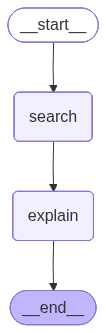

In [11]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

graph = StateGraph(GraphState)
graph.add_node("explain", explain)
graph.add_node("search", search)
graph.add_edge(START, "search")
graph.add_edge("search", "explain")
graph.add_edge("explain", END)

app = graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

## Testing Our Graph

Let's create a helper function to pretty print our results

In [9]:
def ask(question: str):
    for output in app.stream({"question": question}, stream_mode="updates"):
        if END in output or START in output:
            continue
        # Print any node outputs
        for key, value in output.items():
            if "messages" in value:
                print(value["messages"][0].content)


Finally, let's test our chatbot out and see how it works!

In [12]:
question = "What is complexity economics?"
ask(question)

Alright, imagine you have a big box of colorful building blocks. Each block is a different shape and color, and they can all connect in different ways. Now, let's say you and your friends are playing with these blocks. You each have your own ideas about what to build, and you keep changing your mind based on what your friends are doing. Sometimes you make a tall tower, sometimes a long road, and sometimes a funny-looking house.

Complexity economics is like watching how you and your friends play with those blocks. It’s about understanding how all the different pieces (like people, businesses, and money) in the economy fit together and change over time. Just like your building blocks, the economy is always changing because people are always making new decisions and trying new things. Complexity economics helps us see the patterns and surprises that happen when everyone is playing and building together, even if things don’t always fit perfectly or stay the same.
